In [1]:
import os
os.chdir('../..')
import numpy as np
import torch
import pickle
from tqdm import tqdm
from rdkit.Chem import MolFromInchi
from rdkit.Chem.rdmolops import Kekulize
from sklearn.model_selection import KFold


RDKit WARNING: [17:47:22] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from molgrad.utils import DATA_PATH, EXAMPLE_PATH, MODELS_PATH
from molgrad.vis import molecule_importance
from molgrad.net import MPNNPredictor
from molgrad.train import DEVICE, SEED, N_FOLDS

Using backend: pytorch


In [3]:
FOLD_NO = 7

with open(os.path.join(DATA_PATH, "ppb", "data_ppb.pt"), "rb") as handle:
            inchis, values = pickle.load(handle)

inchis = np.array(inchis)
values = np.array(values)[:, np.newaxis]

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
_, idx_test =  list(kf.split(inchis))[FOLD_NO]

inchis, values = inchis[idx_test].tolist(), values[idx_test, :].squeeze().tolist()


In [4]:
sim = np.load(os.path.join(DATA_PATH, "ppb", f"sim_ppb_fold{FOLD_NO}.npy"))
preds = np.load(os.path.join(DATA_PATH, "ppb", f"preds_fold{FOLD_NO}.npy"))
diff_true = np.load(os.path.join(DATA_PATH, "ppb", f"diff_exp_fold{FOLD_NO}.npy"))
diff_hat = np.load(os.path.join(DATA_PATH, "ppb", f"diff_hat_fold{FOLD_NO}.npy"))

In [5]:
sim.shape

(462, 462)

In [6]:
diff_true.shape

(462, 462)

In [7]:
diff_hat.shape

(462, 462)

In [8]:
preds.shape

(462,)

In [9]:
len(inchis)

462

In [10]:
ligand_i = []
ligand_j = []
values_i = []
values_j = []
preds_i = []
preds_j = []

long_sim = []
long_true = []
long_hat = []

for idx_i, (inchi_i, exp_i, pred_i) in enumerate(zip(inchis, values, preds)):
    for idx_j, (inchi_j, exp_j, pred_j) in enumerate(zip(inchis, values, preds)):
        if idx_i < idx_j:
            ligand_i.append(inchi_i)
            ligand_j.append(inchi_j)
            values_i.append(exp_i)
            values_j.append(exp_j)
            preds_i.append(pred_i)
            preds_j.append(pred_j)
            long_sim.append(sim[idx_i, idx_j])
            long_true.append(diff_true[idx_i, idx_j])
            long_hat.append(diff_hat[idx_i, idx_j])

In [11]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

df_pairs = pd.DataFrame({'inchi_i': ligand_i,
                         'inchi_j': ligand_j,
                         'values_i': values_i,
                         'values_j': values_j,
                         'preds_i': preds_i,
                         'preds_j': preds_j,
                         'similarity': long_sim,
                         'diff_exp': long_true,
                         'diff_pred': long_hat})


In [12]:
def sali_index(sim, diff):
    return np.abs(diff) / (1 - sim)

In [13]:
df_pairs = df_pairs.loc[df_pairs['similarity'] < 1.0]
df_pairs['sali_exp'] = sali_index(df_pairs['similarity'], df_pairs['diff_exp'])
df_pairs['sali_pred'] = sali_index(df_pairs['similarity'], df_pairs['diff_pred'])
df_pairs.sort_values('sali_pred', ascending=False, inplace=True)
df_pairs.reset_index(inplace=True)

In [14]:
df_pairs.head(n=50)

,index,inchi_i,inchi_j,values_i,values_j,preds_i,preds_j,similarity,diff_exp,diff_pred,sali_exp,sali_pred
0,97843,InChI=1S/C16H17N3O4S/c1-8-7-24-15-11(14(21)19(...,InChI=1S/C16H17N3O4S.H2O/c1-8-7-24-15-11(14(21...,15.000000,14.500000,12.611216,8.427002,0.985075,0.500000,4.184214,33.500028,280.342548
1,105671,InChI=1S/C24H35BrN4O2/c1-16(26-2)23(30)27-21-5...,InChI=1S/C24H35N5O4/c1-16(25-2)23(30)26-21-5-3...,83.000000,53.000000,87.456154,43.242779,0.828283,30.000000,44.213375,174.705887,257.477897
2,21490,InChI=1S/C21H32N6O3/c1-4-19(28)27(18-9-7-6-8-1...,InChI=1S/C12H11N/c1-3-7-11(8-4-1)13-12-9-5-2-6...,91.000000,99.500000,80.820824,16.182053,0.645161,-19.666668,64.638771,55.424243,182.163799
3,101136,InChI=1S/C28H39N2O2S/c1-22-11-12-25(33-22)15-2...,InChI=1S/C30H42N3O2/c1-24-13-14-25(22-31-24)10...,98.900000,86.100000,98.122612,53.383099,0.752212,12.800000,44.739513,51.657147,180.555905
4,95047,InChI=1S/C25H32N4O5S/c1-27(2)22(30)15-29-21-14...,InChI=1S/C29H35N3O4/c1-30(2)17-26(33)31(3)21-1...,1.100000,99.500000,6.718865,101.603775,0.463235,-98.400002,-94.884911,183.320549,176.771886
5,85018,InChI=1S/C29H37N3O3/c1-30(2)15-16-31(3)22-18-3...,InChI=1S/C25H32N4O5S/c1-27(2)22(30)15-29-21-14...,96.900000,1.100000,101.959442,6.718865,0.437956,95.800003,95.240578,170.449359,169.454018
6,8359,InChI=1S/C16H16N4O8S/c1-26-19-9(8-3-2-4-27-8)1...,InChI=1/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9-...,32.000000,85.000000,6.946593,86.456078,0.492537,-79.000000,-79.509483,155.676472,156.680454
7,95025,InChI=1S/C25H32N4O5S/c1-27(2)22(30)15-29-21-14...,InChI=1S/C25H26N2O3/c1-26-14-18-9-5-6-10-19(18...,1.100000,99.700000,6.718865,98.085457,0.396947,-98.599998,-91.366592,163.501267,151.506632
8,101135,InChI=1S/C28H39N2O2S/c1-22-11-12-25(33-22)15-2...,"InChI=1S/C29H40N3O2/c1-29(26-12-4-2-5-13-26,31...",98.900000,80.000000,98.122612,58.173538,0.704348,18.900000,39.949074,63.926474,135.121878
9,67202,InChI=1/C15H23N3O2.ClH/c1-4-18(5-2)11-10-16-15...,InChI=1/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9-...,10.000000,85.000000,5.210905,86.456078,0.392405,-75.000000,-81.245171,123.437500,133.716010


In [15]:
model_pt = os.path.join(MODELS_PATH, f'ppb_noHs_fold{FOLD_NO}.pt')

model = MPNNPredictor(node_in_feats=49,
                      edge_in_feats=10,
                      global_feats=4,
                      n_tasks=1).to(DEVICE) 
model.load_state_dict(torch.load(model_pt,
                                 map_location=DEVICE))

<All keys matched successfully>

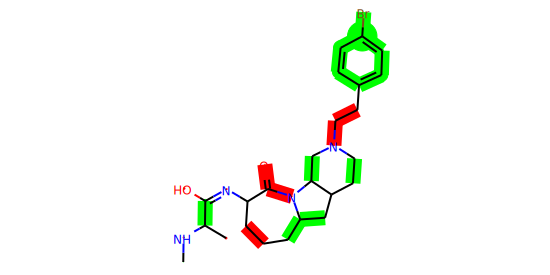

In [16]:
inchi_i, inchi_j = df_pairs.loc[1, 'inchi_i'],  df_pairs.loc[1, 'inchi_j']
mol_i, mol_j = MolFromInchi(inchi_i), MolFromInchi(inchi_j)
# Kekulize(mol_i)
# Kekulize(mol_j)
svg, img, _, _, global_importance = molecule_importance(mol_i,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=0.5,
                                                      eps=1e-4,
                                                      addHs=False,
                                                      img_height=275,
                                                      img_width=550)
img

In [17]:
with open(os.path.join(EXAMPLE_PATH, "ppb_cliff_oof_pos_kekule.svg"), "w+") as handle:
    handle.write(svg)

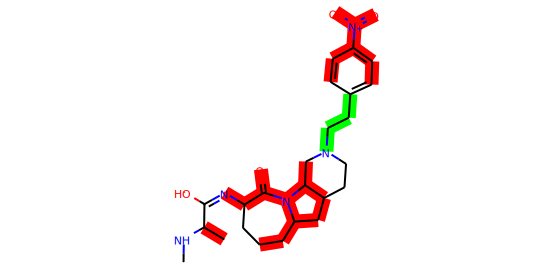

In [18]:
svg, img, _, _, global_importance = molecule_importance(mol_j,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=0.1,
                                                      eps=1e-4,
                                                      addHs=False,
                                                      img_height=275,
                                                      img_width=550)
img

In [19]:
with open(os.path.join(EXAMPLE_PATH, "ppb_cliff_oof_neg_kekule.svg"), "w+") as handle:
    handle.write(svg)